Stream inference with a machine vision camera

# Import

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from IPython.core.debugger import set_trace
from PIL import Image

from style_transfer.data import *
from style_transfer.models import *

In [2]:
sys.path.append('../multi_pyspin/')

In [3]:
import multi_pyspin

19061245 - connected


# Config

In [4]:
file_yaml = Path('cam.yaml')

In [5]:
file_model = Path('training/attempt_4/checkpoints/stage1.pth')

In [6]:
sz = (128, 128)

# Test

Setup camera

In [7]:
serial = multi_pyspin.setup(file_yaml.as_posix())

19061245 - setting up...
19061245 - executing: "UserSetSelector.SetValue(PySpin.UserSetDefault_Default)"
19061245 - executing: "UserSetLoad.Execute()"
19061245 - executing: "LineSelector.SetValue(PySpin.LineSelector_Line2)"
19061245 - executing: "V3_3Enable.SetValue(True)"
19061245 - executing: "AcquisitionFrameRateEnable.SetValue(True)"
19061245 - executing: "AcquisitionFrameRate.SetValue(5)"
19061245 - executing: "ExposureMode.SetValue(PySpin.ExposureMode_Timed)"
19061245 - executing: "ExposureAuto.SetValue(PySpin.ExposureAuto_Off)"
19061245 - executing: "ExposureTime.SetValue(60000)"
19061245 - executing: "GainSelector.SetValue(PySpin.GainSelector_All)"
19061245 - executing: "GainAuto.SetValue(PySpin.GainAuto_Off)"
19061245 - executing: "Gain.SetValue(6)"
19061245 - executing: "BlackLevelSelector.SetValue(PySpin.BlackLevelSelector_All)"
19061245 - executing: "BlackLevel.SetValue(0)"
19061245 - executing: "GammaEnable.SetValue(False)"
19061245 - executing: "PixelFormat.SetValue(PySpi

In [8]:
multi_pyspin.node_cmd(serial, 'TLStream.StreamBufferHandlingMode', 'SetValue', 'RW', 'PySpin.StreamBufferHandlingMode_NewestOnly')
multi_pyspin.node_cmd(serial, 'AcquisitionMode', 'SetValue', 'RW', 'PySpin.AcquisitionMode_Continuous')

19061245 - executing: "TLStream.StreamBufferHandlingMode.SetValue(PySpin.StreamBufferHandlingMode_NewestOnly)"
19061245 - executing: "AcquisitionMode.SetValue(PySpin.AcquisitionMode_Continuous)"


In [9]:
multi_pyspin.start_acquisition(serial)

Load model

In [10]:
# Model
in_channels  = 3
layout_encoder = [[  32, 7, 1],
                  [  64, 5, 1],
                  [ 128, 3, 1],
                  [ 256, 3, 8]]
model = AutoEncoder(get_encoder(in_channels, layout_encoder))
model = model.cuda()
model.load_state_dict(torch.load(file_model)['model']);

Stream images

In [11]:
def _get_img():
    return multi_pyspin.get_image(serial)['image'].GetNDArray() # Might result in mem leak

In [12]:
def _format_img(img):
    img = Image.fromarray(img/(2**16-1))
    img = F.resize(img, sz)
    img = F.center_crop(img, sz)
    img = np.array(img, dtype=np.float32)
    img = np.tile(img[:,:,None], (1,1,3))
    return img

In [13]:
def _get_style_transfer(img):
    # Tensorify image and send to device
    img = F.to_tensor(img)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img[None].to('cuda')
    # Do inference
    model.eval()
    with torch.no_grad():
        img = model(img)
    img = torch2np(img[0])
    img = denorm(img)
    return img

<IPython.core.display.Javascript object>


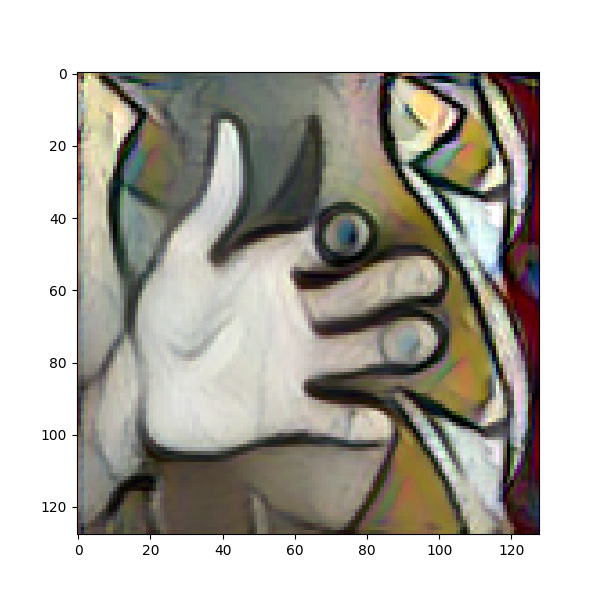

In [14]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(6, 6))
imshow = ax.imshow(np.ones((sz[1], sz[0], 3)), vmin=0, vmax=1)
fig.canvas.draw()
try:
    while True:
        # Get mask
        img = _get_img()
        img = _format_img(img)
        img = _get_style_transfer(img)
        
        # Plot
        imshow.set_data(img)
        fig.canvas.draw()
        
except KeyboardInterrupt:
    pass

%matplotlib inline

Cleanup

In [ ]:
multi_pyspin.end_acquisition(serial)
multi_pyspin.deinit(serial)